<a href="https://www.kaggle.com/code/akshitagupta1506/emotion-recognition-ckplus-cnn?scriptVersionId=154576302" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [87]:
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations and working with arrays
import cv2 as cv  # For image processing tasks
import os  # For interacting with the operating system, like file paths
import tensorflow as tf  # For building and training neural network models

from keras.preprocessing.image import ImageDataGenerator  # For real-time data augmentation
from tensorflow.keras.models import load_model  # For loading a saved Keras model
from keras.models import Sequential  # For creating a linear stack of layers in the model
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten  # For building model layers
from keras.optimizers import Adam  # For optimization algorithms
from keras.layers import BatchNormalization  # For applying Batch Normalization in neural network layers
from keras.regularizers import l2  # For applying L2 regularization to prevent overfitting
from keras.callbacks import ReduceLROnPlateau, EarlyStopping  # Importing specific callback functions

import warnings  # For handling warnings
import sys  # For interacting with the Python interpreter
if not sys.warnoptions:
    warnings.simplefilter("ignore")  # Ignore simple warnings if not already done
warnings.filterwarnings("ignore", category=DeprecationWarning)  # Ignore deprecation warnings

In [88]:
import shutil

# Define the path to your original dataset and the paths where you want to store your train and test datasets
original_dataset_dir = '/kaggle/input/ckplus/CK+48'
train_dir = 'CK+48_train'
test_dir = 'CK+48_test'

# Create directories for training and testing datasets if they do not exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Define the split ratio
train_ratio = 0.8

# Loop through each emotion category in the original dataset
for emotion in os.listdir(original_dataset_dir):
    emotion_dir = os.path.join(original_dataset_dir, emotion)
    if os.path.isdir(emotion_dir):
        # Get a list of all the image filenames in the emotion category
        images = [f for f in os.listdir(emotion_dir) if os.path.isfile(os.path.join(emotion_dir, f))]
        
        # Randomly shuffle the list of image filenames
        np.random.shuffle(images)
        
        # Split the list of image filenames into training and testing sets
        train_size = int(len(images) * train_ratio)
        train_images = images[:train_size]
        test_images = images[train_size:]
        
        # Create directories for the emotion category in the train and test datasets
        train_emotion_dir = os.path.join(train_dir, emotion)
        test_emotion_dir = os.path.join(test_dir, emotion)
        os.makedirs(train_emotion_dir, exist_ok=True)
        os.makedirs(test_emotion_dir, exist_ok=True)
        
        # Copy the images into the corresponding directories
        for image in train_images:
            shutil.copy(os.path.join(emotion_dir, image), os.path.join(train_emotion_dir, image))
        for image in test_images:
            shutil.copy(os.path.join(emotion_dir, image), os.path.join(test_emotion_dir, image))

print("Dataset splitting complete")

Dataset splitting complete


In [89]:
import cv2

# Load the image
img = cv2.imread('/kaggle/input/smiling/42730583-she-got-beautiful-smile-portrait-of-cheerful-young-woman-looking-at-camera-and-smiling-while.jpg')

# Get dimensions
height, width, channels = img.shape
print(f'Dimensions: {width}x{height}')
# Create a data generator with augmentation
train_data_generator = ImageDataGenerator(
    rescale=1./255,  # Rescale the pixel values (normalization)
    rotation_range=15,  # Random rotation in the range of 15 degrees
    width_shift_range=0.15,  # Random horizontal shifts (15% of total width)
    height_shift_range=0.15,  # Random vertical shifts (15% of total height)
    shear_range=0.15,  # Random shearing transformations
    zoom_range=0.15,  # Random zoom range
    horizontal_flip=True,  # Randomly flip inputs horizontally
)

# Load images from the directory and apply the defined transformations
fer_training_data = train_data_generator.flow_from_directory(
    '/kaggle/working/CK+48_train',  # Path to the training data
    target_size=(48, 48),  # Resize images to 48x48
    batch_size=64,  # Number of images to yield per batch
    color_mode='grayscale',  # Load images in grayscale
    class_mode='categorical'  # Labels will be returned in categorical format
)

fer_training_data

Dimensions: 1300x867
Found 980 images belonging to 7 classes.


In [90]:
# Initialize an ImageDataGenerator for test data with rescaling
# Rescales images by dividing pixel values by 255 (normalization)
test_data_generator = ImageDataGenerator(rescale=1./255)

# Creates a data generator for the test dataset
# flow_from_directory method loads images from a directory,
# in this case, '/kaggle/working/CK+48_test'
fer_test_data = test_data_generator.flow_from_directory(
    '/kaggle/working/CK+48_test',  # Directory path for test images
    target_size = (48, 48),  # Resizes images to 48x48 pixels
    batch_size = 64,  # Number of images to yield per batch
    color_mode = 'grayscale',  # Specifies that images are in grayscale
    class_mode = 'categorical'  # Images are classified categorically
)

# fer_test_data is now a generator that yields batches of test images and their labels
fer_test_data

Found 730 images belonging to 7 classes.


In [91]:
# Importing the optimizers module from TensorFlow's Keras library
from tensorflow.keras import optimizers

# Initializing a list of optimizers with specific configurations
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]

In [92]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()

model.add(
        Conv2D(
            filters=512,
            kernel_size=(5,5),
            input_shape=(48, 48, 1),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
model.add(BatchNormalization(name='batchnorm_1'))
model.add(
        Conv2D(
            filters=256,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
model.add(BatchNormalization(name='batchnorm_2'))
    
model.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
model.add(Dropout(0.25, name='dropout_1'))

model.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
model.add(BatchNormalization(name='batchnorm_3'))
model.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
model.add(BatchNormalization(name='batchnorm_4'))
    
model.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
model.add(Dropout(0.25, name='dropout_2'))

model.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
model.add(BatchNormalization(name='batchnorm_5'))
model.add(
        Conv2D(
            filters=512,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
model.add(BatchNormalization(name='batchnorm_6'))
    
model.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
model.add(Dropout(0.25, name='dropout_3'))

model.add(Flatten(name='flatten'))
model.add(
        Dense(
            256,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
model.add(BatchNormalization(name='batchnorm_7'))
    
model.add(Dropout(0.25, name='dropout_4'))
    
model.add(
        Dense(
            7,
            activation='softmax',
            name='out_layer'
        )
    )
    
model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 512)       13312     
                                                                 
 batchnorm_1 (BatchNormaliz  (None, 48, 48, 512)       2048      
 ation)                                                          
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 256)       3277056   
                                                                 
 batchnorm_2 (BatchNormaliz  (None, 48, 48, 256)       1024      
 ation)                                                          
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 256)       0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 256)      

In [93]:
# Reduce learning rate when a metric has stopped improving
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [94]:
main_folder = "../input/celeba-dataset/"
images_folder = main_folder + "img_align_celeba/img_align_celeba/"

example_pic = images_folder + "000506.jpg"

training_sample = 10000
validation_sample = 2000
test_sample = 2000
img_width = 178
img_height = 218
batch_size = 16
num_epochs = 5

In [95]:
batch_size = 64
history = model.fit(
    fer_training_data,
    epochs=50, 
    validation_data=fer_test_data,
    batch_size = 64,
    callbacks=callbacks,
)

Epoch 1/50


2023-12-11 18:46:10.176673: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


16/16 [==============================] - 11s 375ms/step - loss: 2.3766 - accuracy: 0.3245 - val_loss: 117.9992 - val_accuracy: 0.2329 - lr: 0.0010
Epoch 2/50
16/16 [==============================] - 2s 146ms/step - loss: 1.4498 - accuracy: 0.5000 - val_loss: 35.4589 - val_accuracy: 0.0863 - lr: 0.0010
Epoch 3/50
16/16 [==============================] - 2s 144ms/step - loss: 1.1813 - accuracy: 0.5776 - val_loss: 13.8667 - val_accuracy: 0.1411 - lr: 0.0010
Epoch 4/50
16/16 [==============================] - 2s 147ms/step - loss: 1.0810 - accuracy: 0.6224 - val_loss: 4.6493 - val_accuracy: 0.2795 - lr: 0.0010
Epoch 5/50
16/16 [==============================] - 2s 147ms/step - loss: 0.9199 - accuracy: 0.6622 - val_loss: 1.0643 - val_accuracy: 0.7274 - lr: 0.0010
Epoch 6/50
16/16 [==============================] - 2s 144ms/step - loss: 0.8358 - accuracy: 0.6918 - val_loss: 1.7935 - val_accuracy: 0.5479 - lr: 0.0010
Epoch 7/50
16/16 [==============================] - 2s 146ms/step - loss: 0.

In [96]:
import plotly.graph_objects as go

# Create traces
fig = go.Figure()

# Training vs. Validation Accuracy
fig.add_trace(go.Scatter(x=list(range(1, len(history.history['accuracy']) + 1)), y=history.history['accuracy'], mode='lines+markers', name='Training Accuracy'))
fig.add_trace(go.Scatter(x=list(range(1, len(history.history['val_accuracy']) + 1)), y=history.history['val_accuracy'], mode='lines+markers', name='Validation Accuracy'))

# Layout for Accuracy
fig.update_layout(title='Training vs. Validation Accuracy', xaxis_title='Epoch', yaxis_title='Accuracy', template="plotly_white")

# Show the plot
fig.show()

# New figure for loss
fig = go.Figure()

# Training vs. Validation Loss
fig.add_trace(go.Scatter(x=list(range(1, len(history.history['loss']) + 1)), y=history.history['loss'], mode='lines+markers', name='Training Loss'))
fig.add_trace(go.Scatter(x=list(range(1, len(history.history['val_loss']) + 1)), y=history.history['val_loss'], mode='lines+markers', name='Validation Loss'))

# Layout for Loss
fig.update_layout(title='Training vs. Validation Loss', xaxis_title='Epoch', yaxis_title='Loss', template="plotly_white")

# Show the plot
fig.show()

In [97]:
# Evaluate the model on the validation dataset
loss, accuracy = model.evaluate(fer_test_data, verbose=1)

# Print the loss and accuracy
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

12/12 [==============================] - 0s 32ms/step - loss: 0.0146 - accuracy: 0.9959
Validation Loss: 0.014586555771529675
Validation Accuracy: 99.59%


1/1 [==============================] - 0s 165ms/step


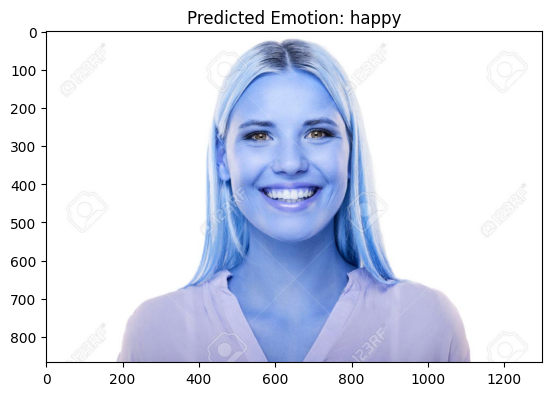

In [98]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image (replace 'path_to_your_image' with the actual path)
image_path = '/kaggle/input/smiling/42730583-she-got-beautiful-smile-portrait-of-cheerful-young-woman-looking-at-camera-and-smiling-while.jpg'
image = cv2.imread(image_path)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert color format to grayscale

# Preprocess the image (adjust as per your model's requirements)
desired_width, desired_height = 48, 48  # Adjust as needed
gray_image = cv2.resize(gray_image, (desired_width, desired_height))
gray_image = gray_image / 255.0  # Normalize the pixel values to the range [0, 1]

# Ensure the input shape matches the model's expectation for grayscale images
gray_image = np.reshape(gray_image, (desired_width, desired_height))

# Make predictions using your trained model
predictions = model.predict(np.reshape(gray_image, (1, desired_width, desired_height, 1)))

# Extract predicted emotion class
emotion_classes = ["fear", "disgust", "happy", "anger", "surprise", "Contempt", "sadness"]
predicted_emotion_index = np.argmax(predictions)
predicted_emotion = emotion_classes[predicted_emotion_index]

# Show the image using matplotlib
plt.imshow(image)
plt.title(f'Predicted Emotion: {predicted_emotion}')
plt.show()



